In [1]:
import numpy as np
from pickle import load
import matplotlib.pyplot as plt

In [2]:
data_path = "../Datos/Procesados/results_3d/skeleton_uplift.pkl"

with open(data_path, "rb") as f:
    data = load(f)

In [3]:
data["A"].keys()

dict_keys(['body2d', 'right2d', 'left2d', 'success_right', 'success_left', 'poses_3d_clamped', 'poses_3d_filtered', 'poses_3d', 'body_angles', 'right_angles', 'left_angles', 'body_offsets', 'hand_offsets', 'frames_list', 'video_name'])

In [4]:
data["A"]["body2d"].dtype

dtype('float32')

In [5]:
data["A"]['right2d'][50]

array([[130.9393 , 156.07422],
       [134.06953, 143.01826],
       [142.143  , 133.83247],
       [150.5517 , 129.91711],
       [156.92885, 128.60329],
       [145.38959, 135.55467],
       [158.98886, 132.5962 ],
       [155.25539, 135.4288 ],
       [149.8409 , 137.29434],
       [147.48364, 143.4676 ],
       [159.8936 , 140.98859],
       [156.17505, 142.99994],
       [150.96373, 144.41583],
       [148.98776, 151.47696],
       [159.8416 , 148.41536],
       [156.50674, 150.15253],
       [151.50386, 151.78923],
       [149.79947, 158.93323],
       [158.50554, 155.12332],
       [155.35138, 156.15903],
       [151.13072, 157.87845]], dtype=float32)

In [6]:
def get_dtype(n, only_positives = True):
    if only_positives:
        if n<2**8:
            return np.uint8
        elif n<2**16:
            return np.uint16
        elif n<2**32:
            return np.uint32
        return np.uint64
    else:
        if n<2**7:
            return np.int8
        elif n<2**15:
            return np.int16
        elif n<2**31:
            return np.int32
        return np.int64

In [7]:
def track_wrist(data, letter, side, version="_filtered"):
    if side=="right":
        n_side = 0
    elif side=="left":
        n_side = 1
    else:
        raise Exception('Parameter "side" must be either "right" or "left".')

    tracking = {}

    success = data[letter]["success_"+side]
    tracking["total_frames"] = success.size
    tracking["frames"] = np.arange(success.size, dtype=get_dtype(success.size))[success]

    ranges = []
    starting = True
    I = len(tracking["frames"]) - 1
    for i, frame in enumerate(tracking["frames"]):
        ending = (i==I) or (tracking["frames"][i+1] != frame+1)
        if starting:
            start = frame
        if ending:
            ranges.append((start, frame+1))
        starting = ending
    tracking["continuity_ranges"] = ranges

    tracking["position_2d"] = data[letter]["body2d"][success, 2+3*n_side] - data[letter]["body2d"][success, 3*n_side]
    tracking["position_3d"] = data[letter]["poses_3d"+version][success, 2+3*n_side] - data[letter]["poses_3d"+version][success, 3*n_side]

    speed_2d = np.empty(tracking["frames"].size, dtype=tracking["position_2d"].dtype)
    speed_3d = np.empty(tracking["frames"].size, dtype=tracking["position_3d"].dtype)
    velocity_dir_2d = np.empty(tracking["position_2d"].shape, dtype=tracking["position_2d"].dtype)
    velocity_dir_3d = np.empty(tracking["position_3d"].shape, dtype=tracking["position_3d"].dtype)

    tang_acc_2d = np.empty(tracking["frames"].size, dtype=tracking["position_2d"].dtype)
    tang_acc_3d = np.empty(tracking["frames"].size, dtype=tracking["position_3d"].dtype)
    norm_acc_2d = np.empty(tracking["frames"].size, dtype=tracking["position_2d"].dtype)
    norm_acc_3d = np.empty(tracking["frames"].size, dtype=tracking["position_3d"].dtype)
    normal_dir_2d = np.empty(tracking["position_2d"].shape, dtype=tracking["position_2d"].dtype)
    normal_dir_3d = np.empty(tracking["position_3d"].shape, dtype=tracking["position_3d"].dtype)

    i = 0
    for start, end in ranges:
        if end==start+1:
            speed_2d[i] = np.nan
            speed_3d[i] = np.nan
            velocity_dir_2d[i] = np.nan
            velocity_dir_3d[i] = np.nan
            tang_acc_2d[i] = np.nan
            tang_acc_3d[i] = np.nan
            norm_acc_2d[i] = np.nan
            norm_acc_3d[i] = np.nan
            normal_dir_2d[i] = np.nan
            normal_dir_3d[i] = np.nan
            i += 1
            continue
        sum_index = np.arange(i+1, i+end-start+1)
        sum_index[-1] = sum_index[-2]
        sub_index = np.arange(i-1, i+end-start-1)
        sub_index[0] = sub_index[1]


        velocity_2d = (tracking["position_2d"][sum_index] - tracking["position_2d"][sub_index]) / 2.
        velocity_2d[0] *= 2
        velocity_2d[-1] *= 2
        speed_2d[i: i+end-start] = np.linalg.norm(velocity_2d, axis=1)
        velocity_dir_2d[i: i+end-start] = velocity_2d / speed_2d[i: i+end-start].reshape(-1, 1)

        velocity_3d = (tracking["position_3d"][sum_index] - tracking["position_3d"][sub_index]) / 2.
        velocity_3d[0] *= 2
        velocity_3d[-1] *= 2
        speed_3d[i: i+end-start] = np.linalg.norm(velocity_3d, axis=1)
        velocity_dir_3d[i: i+end-start] = velocity_3d / speed_3d[i: i+end-start].reshape(-1, 1)


        tang_acc_2d[i: i+end-start] = (speed_2d[sum_index] - speed_2d[sub_index]) / 2.
        tang_acc_2d[i] *= 2
        tang_acc_2d[i+end-start-1] *= 2

        normal_vector_2d = (velocity_dir_2d[sum_index] - velocity_dir_2d[sub_index]) / 2.
        normal_vector_2d[0] *= 2
        normal_vector_2d[-1] *= 2
        normal_length_2d = np.linalg.norm(normal_vector_2d, axis=1)
        norm_acc_2d[i: i+end-start] = speed_2d[i: i+end-start] * normal_length_2d

        tang_acc_3d[i: i+end-start] = (speed_3d[sum_index] - speed_3d[sub_index]) / 2.
        tang_acc_3d[i] *= 2
        tang_acc_3d[i+end-start-1] *= 2

        normal_vector_3d = (velocity_dir_3d[sum_index] - velocity_dir_3d[sub_index]) / 2.
        normal_vector_3d[0] *= 2
        normal_vector_3d[-1] *= 2
        normal_length_3d = np.linalg.norm(normal_vector_3d, axis=1)
        norm_acc_3d[i: i+end-start] = speed_3d[i: i+end-start] * normal_length_3d

        if end==start+2:
            normal_dir_2d[i: i+end-start] = np.nan
            normal_dir_3d[i: i+end-start] = np.nan
        else:
            normal_dir_2d[i: i+end-start] = normal_vector_2d / normal_length_2d.reshape(-1, 1)
            normal_dir_3d[i: i+end-start] = normal_vector_3d / normal_length_3d.reshape(-1, 1)

        i += end-start

    tracking["speed_2d"] = speed_2d
    tracking["velocity_direction_2d"] = velocity_dir_2d
    tracking["tangencial_acceleration_2d"] = tang_acc_2d
    tracking["normal_acceleration_2d"] = norm_acc_2d
    tracking["normal_direction_2d"] = normal_dir_2d

    tracking["speed_3d"] = speed_3d
    tracking["velocity_direction_3d"] = velocity_dir_3d
    tracking["tangencial_acceleration_3d"] = tang_acc_3d
    tracking["normal_acceleration_3d"] = norm_acc_3d
    tracking["normal_direction_3d"] = normal_dir_3d

    return tracking

In [56]:
track_wrist(data, "A", "right")["speed_2d"] < 0.1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False])

In [9]:
def plot_tracking(data, letter, side, version="_filtered"):
    wrist_tracking = track_wrist(data, letter, side, version)
    
    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 9))
    plt.subplots_adjust(hspace=0.06)
    fig.suptitle("LETTER %s - %s WRIST" % (letter, side.upper()), y=0.95)
    
    axs[1, 0].set_xlim(xmin=0, xmax=wrist_tracking["total_frames"]-1)
    axs[1, 1].set_xlim(xmin=0, xmax=wrist_tracking["total_frames"]-1)
    
    axs[0, 0].set_title("Speed", y=1.03)
    axs[0, 1].set_title("Accelerations", y=1.03)
    axs[0, 0].set_ylabel("2D", labelpad=12, rotation=0)
    axs[1, 0].set_ylabel("3D", labelpad=12, rotation=0)
    
    i = 0
    for start, end in wrist_tracking["continuity_ranges"]:
        axs[0, 0].plot(wrist_tracking["frames"][i: i+end-start], wrist_tracking["speed_2d"][i: i+end-start], 'b')
        axs[1, 0].plot(wrist_tracking["frames"][i: i+end-start], wrist_tracking["speed_3d"][i: i+end-start], 'b')
        axs[0, 1].plot(wrist_tracking["frames"][i: i+end-start], wrist_tracking["tangencial_acceleration_2d"][i: i+end-start], 'b')
        axs[0, 1].plot(wrist_tracking["frames"][i: i+end-start], wrist_tracking["normal_acceleration_2d"][i: i+end-start], 'r')
        axs[1, 1].plot(wrist_tracking["frames"][i: i+end-start], wrist_tracking["tangencial_acceleration_3d"][i: i+end-start], 'b')
        axs[1, 1].plot(wrist_tracking["frames"][i: i+end-start], wrist_tracking["normal_acceleration_3d"][i: i+end-start], 'r')
        i += end-start
    
    axs[0, 1].plot([], [], 'b', label="Tangential")
    axs[0, 1].plot([], [], 'r', label="Normal")
    axs[1, 1].plot([], [], 'b', label="Tangential")
    axs[1, 1].plot([], [], 'r', label="Normal")
    axs[0, 1].legend()
    axs[1, 1].legend()
    
    plt.show()

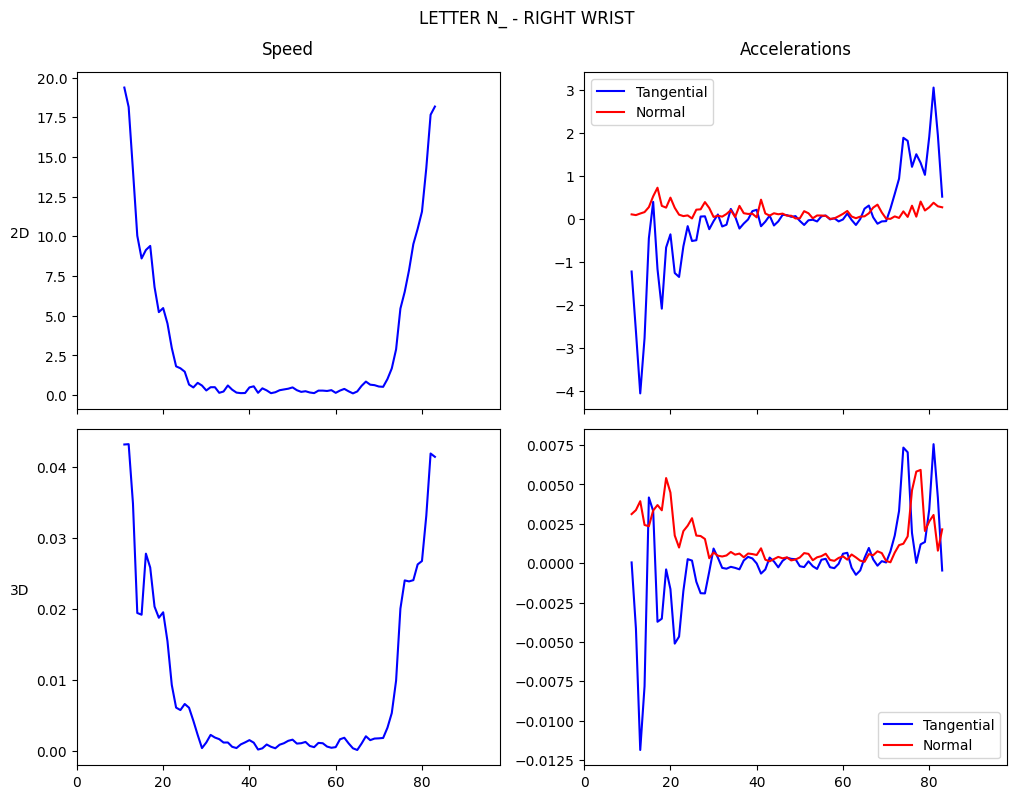

In [42]:
letter = "N_"
side = "right"
plot_tracking(data, letter, side)

In [61]:
def _side_is_static(data, letter, side, tol=0.1, version="_filtered"):
    wrist_tracking = track_wrist(data, letter, side, version)        

    frames = wrist_tracking["frames"][wrist_tracking["speed_2d"] < tol]
    if (not wrist_tracking["frames"].size) or (frames.size > 2 and frames[-1] - frames[0] < frames.size):
        return True
    return False

def is_static(data, letter, tol=0.1, version="_filtered"):
    return _side_is_static(data, letter, "right", tol, version) and _side_is_static(data, letter, "left", tol, version)

In [65]:
for letter in data.keys():
    print(letter, is_static(data, letter, tol=0.095))

A True
B True
C True
CH False
D False
E False
F False
G False
H False
I False
J False
K True
L False
LL False
M False
N False
N_ False
O False
P False
Q False
R False
RR False
S False
T False
U False
V False
W False
X False
Y False
Z False


## Finding pauses

Posibilidades:
- Suavizar y buscar mínimos
- Cosas de Ignacio: normalización, distancia de Frechet discreta (https://arxiv.org/abs/2404.05708):
  - Python: https://github.com/avitase/fast_frechet-python
  - C++/SIMD/CUDA: https://github.com/avitase/fast_frechet
- https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array